<a href="https://colab.research.google.com/github/RachelRamirez/misclassification_matrix/blob/main/30_Runs_of_Baseline_40D_with_SGD_LR_0point01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# How to change the local time in Google Colab
!rm /etc/localtime
!ln -s /usr/share/zoneinfo/US/Eastern /etc/localtime
!date

#If this doesn't show the local time correctly, then you need to restart.
import time
time.localtime(time.time())

Mon 01 May 2023 03:17:38 PM EDT


time.struct_time(tm_year=2023, tm_mon=5, tm_mday=1, tm_hour=15, tm_min=17, tm_sec=38, tm_wday=0, tm_yday=121, tm_isdst=1)

We'll start by writing a `.py` file which we'll import.

In [2]:
%%writefile example.py
def f():
  print ('This is a function defined in a Python source file.')

Overwriting example.py


In [3]:
%%writefile ImportLibraries_DefineFunctions.py
import time
time.localtime(time.time())
#For Reproducibility
import numpy as np
# np.random.seed(1337)  # for reproducibility

import tensorflow as tf
# tf.random.set_seed(33)

import random as python_random
# python_random.seed(4)

# https://www.tensorflow.org/api_docs/python/tf/keras/utils/set_random_seed
seed = 342
tf.keras.utils.set_random_seed(seed) #Possibly use next iteration if the above doesn't work   #This makes everything VERY DETERMINISTIC


# Running more than once causes variation.  try adding this:
# Set seed value
seed_value = 56
import os
os.environ['PYTHONHASHSEED']=str(seed_value)

print("TF version: " , tf.__version__ )
print("Keras version: " , tf.keras.__version__ )


 

# from __future__ import print_function  #do i still need this?
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.optimizers import SGD, Adam, RMSprop
from keras.utils import np_utils
import keras.backend as K
from itertools import product
import functools
from functools import partial
from time import ctime
from time import sleep
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd 
from sklearn.metrics import confusion_matrix, classification_report   #CLASSIFICATION REPORT IS FOR F1 SCORE AND BREAKOUT OF AL CATEGORIES ACCURACYS
from  sklearn.utils import shuffle
from sklearn.metrics import f1_score
 
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
K.set_session(sess)

print("Finished Loading Libraries")


batch_size = 256 

# I originally had it very  high batch size to reduce the variation in the data each batch and hope 
# it makes the model training more nearly identical which it did, then i bring it back down to something reasonable to get better results training the NN

nb_classes = 10

# the data, shuffled and split between train and test sets
(X_train, y_train), (X_test, y_test) = mnist.load_data()


X_train = X_train.reshape(60000, 784)
X_test = X_test.reshape(10000, 784)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255
# print(X_train.shape[0], 'train samples')
# print(X_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

#Create a Validation Set
X_val = X_test[:7500]   #take the first 7500 for validation
Y_val = Y_test[:7500]   #Take the first 7500 for validation
y_val = y_test[:7500]

X_test = X_test[7500:]  #Keep the last 2500 for test/holdout
Y_test = Y_test[7500:]  #Keep the last 2500 for test/holdout
y_test = y_test[7500:]

print(X_train.shape[0], 'train samples')
print(X_val.shape[0], 'validation samples')
print(X_test.shape[0], 'test samples')

#Are the sets relatively balanced? Yes each category is between 8% and 11% per category
print('Train', Y_train.sum(axis=0)/X_train.shape[0])
print('Train # of 9s', Y_train.sum(axis=0)[9])
print('Train # of 4s', Y_train.sum(axis=0)[4])

print('Val', Y_val.sum(axis=0)/X_val.shape[0])
print('Val # of 9s', Y_val.sum(axis=0)[9])
print('Val # of 4s', Y_val.sum(axis=0)[4])

print('Test', Y_test.sum(axis=0)/X_test.shape[0])
print('Test  # of 9s', Y_test.sum(axis=0)[9])
print('Test  # of 4s', Y_test.sum(axis=0)[4])

#@title
class WeightedCategoricalCrossentropy(tf.keras.losses.CategoricalCrossentropy):

  def __init__(self, cost_mat, name='weighted_categorical_crossentropy', **kwargs):

    cost_mat = np.array(cost_mat)   
    ## when loading from config, self.cost_mat returns as a list, rather than an numpy array. 
    ## Adding the above line fixes this issue, enabling .ndim to call sucessfully. 
    ## However, this is probably not the best implementation
    assert(cost_mat.ndim == 2)
    assert(cost_mat.shape[0] == cost_mat.shape[1])
    super().__init__(name=name, **kwargs)
    self.cost_mat = K.cast_to_floatx(cost_mat)

  def __call__(self, y_true, y_pred, sample_weight=None):
    assert sample_weight is None, "should only be derived from the cost matrix"  
    return super().__call__(
        y_true=y_true, 
        y_pred=y_pred, 
        sample_weight=get_sample_weights(y_true, y_pred, self.cost_mat),
    )


  def get_config(self):
    config = super().get_config().copy()
    # Calling .update on the line above, during assignment, causes an error with config becoming None-type.
    config.update({'cost_mat': (self.cost_mat)})
    return config

  @classmethod
  def from_config(cls, config):
    # something goes wrong here and changes self.cost_mat to a list variable.
    # See above for temporary fix
    return cls(**config)

def get_sample_weights(y_true, y_pred, cost_m):
    num_classes = len(cost_m)

    y_pred.shape.assert_has_rank(2)
    assert(y_pred.shape[1] == num_classes)
    y_pred.shape.assert_is_compatible_with(y_true.shape)

    y_pred = K.one_hot(K.argmax(y_pred), num_classes)

    y_true_nk1 = K.expand_dims(y_true, 2)
    y_pred_n1k = K.expand_dims(y_pred, 1)
    cost_m_1kk = K.expand_dims(cost_m, 0)

    sample_weights_nkk = cost_m_1kk * y_true_nk1 * y_pred_n1k
    sample_weights_n = K.sum(sample_weights_nkk, axis=[1, 2])

    return sample_weights_n


# Register the loss in the Keras namespace to enable loading of the custom object.
tf.keras.losses.WeightedCategoricalCrossentropy = WeightedCategoricalCrossentropy
 
#@title
def plot_model_history(model_history, nb_epoch, cm3): 
  # Parameters
  # ----------
  # model_history : keras.callbacks.History
  #     The history object returned by the fit() method of the model.
  # cm3 : 10x10 dataframe 
  #      10x10 dataframe of confusion matrix from predicted X_val categories
  # nb_epoch = restored_weights : int
  #     The epoch at which the weights were restored.
  # tot_epochs : int
  #     Calculated Total number of epochs for which the model was trained.
  
   
  tot_epochs = max(model_history.epoch)+1  #if the total epochs ran is 28, it'll show up as 27 in the epoch object so we must add 1
  print("Total Epochs: ", tot_epochs)

  #if tot_epochs is the total number of epochs ran then early stop did not happen, and we need not minus patience
  if tot_epochs == nb_epoch:
    restored_weights = tot_epochs
  else:
    restored_weights  = tot_epochs-patience   #when using restore-best-weights and patience, it'll restore the best weights back
  print("Restored weights at ", restored_weights, "Patience used: ", patience)

  fig = plt.figure(figsize=(20, 10)) # I don't think this works for some reason
  fig, ax = plt.subplots(1,3)
  ax[0].plot(range(1,tot_epochs+1), model_history.history['categorical_accuracy'], color='blue',             label='Training')
  ax[0].plot(range(1,tot_epochs+1), model_history.history['val_categorical_accuracy'] , color='orange',             label='Validation')
  ax[0].scatter((restored_weights), model_history.history['val_categorical_accuracy'][restored_weights-1] , color='orange')
  ax[0].scatter(restored_weights, model_history.history['categorical_accuracy'][restored_weights-1], color='blue')
  ax[0].annotate(text=str(restored_weights),  xy=(restored_weights, model_history.history['val_categorical_accuracy'][restored_weights-1]),
                  textcoords="offset points", xytext=(0,10), ha='center', color='black')
  ax[0].legend()
  ax[0].set_title('Training and Validation Accuracy')

  ax[1].plot(range(1,tot_epochs+1), model_history.history['loss'], color= 'blue', label='Training')
  ax[1].plot(range(1,tot_epochs+1), model_history.history['val_loss'], color='orange', label='Validation')
  ax[1].scatter(restored_weights, model_history.history['loss'][restored_weights-1], color='blue')
  ax[1].scatter((restored_weights), model_history.history['val_loss'][restored_weights-1] , color='orange')
  ax[1].annotate(text=str(restored_weights),  xy=(restored_weights, model_history.history['val_loss'][restored_weights-1]),
                  textcoords="offset points", xytext=(0,10), ha='center')
  ax[1].legend()
  ax[1].set_title('Training and Validation Loss')


  cm3_wodiag = cm3*(np.ones((10,10)) - np.eye(10))

  ax[2] = sns.heatmap(cm3_wodiag, annot=True, annot_kws={"size": 7},  fmt='g', cmap=sns.cm.rocket_r) # font size
  ax[2].set_xlabel('Predicted Class')
  ax[2].set_ylabel('True Class')
  ax[2].set_title('# of misclassifications of 9 as 4 is '+str(cm3[4][9]))
  cbar = ax[2].collections[0].colorbar
  cbar.remove() # Just takes up valuable room and is worthless


  plt.gcf().set_size_inches(15, 5)  # this works 
  # plt.gcf().suptitle(f"Lambda Value {lambda_val} for {nb_epoch} Epochs and Patience {patience} " )


  #@title
def create_model(): #Removed cost-matrix which is called up in the Compile Function and passed to the weighted-loss function
  model = Sequential()
  model.add(Dense(40, input_shape=(784,), kernel_initializer=tf.keras.initializers.glorot_uniform(seed=42)))
  model.add(Activation('relu'))
  model.add(Dropout(0.2))
  model.add(Dense(40, kernel_initializer=tf.keras.initializers.glorot_uniform(seed=42)))
  model.add(Activation('relu'))
  model.add(Dropout(0.2))
  model.add(Dense(10,kernel_initializer=tf.keras.initializers.glorot_uniform(seed=42)))
  model.add(Activation('softmax'))
  return model  #I removed Compile



  #@title
def log_confusion_matrix( epoch, logs):
  # Use the model to predict the values from the validation dataset.
  y_prediction = model.predict(X_val, verbose=0)     #I call it y_prediction3 because I just want to make sure this is  updated within and not interfering with the other prediction below
  y_prediction  = np.argmax(y_prediction, axis=1)

  #Create confusion matrix 
  cm = confusion_matrix(y_val, y_prediction)
  cm_array = np.asarray(cm)  #Indiv CM as array for storing
  logs['9T_4P'] = cm[9,4]
  logs['4T_9P'] = cm[4,9]

  logs['0T_Acc'] = cm[0,0]/np.sum(cm[0])
  logs['1T_Acc'] = cm[1,1]/np.sum(cm[1])
  logs['2T_Acc'] = cm[2,2]/np.sum(cm[2])
  logs['3T_Acc'] = cm[3,3]/np.sum(cm[3])
  logs['4T_Acc'] = cm[4,4]/np.sum(cm[4])
  logs['5T_Acc'] = cm[5,5]/np.sum(cm[5])
  logs['6T_Acc'] = cm[6,6]/np.sum(cm[6])
  logs['7T_Acc'] = cm[7,7]/np.sum(cm[7])
  logs['8T_Acc'] = cm[8,8]/np.sum(cm[8])
  logs['9T_Acc'] = cm[9,9]/np.sum(cm[9])


  logs['cm_per_epoch'] = cm_array.reshape((1,100))

#@title
def log_classification_report( epoch, logs):
  # Use the model to predict the values from the validation dataset.
    y_prediction = model.predict(X_val, verbose=0)     #I call it y_prediction3 because I just want to make sure this is  updated within and not interfering with the other prediction below
    y_prediction  = np.argmax(y_prediction, axis=1)

    #Create confusion matrix 
    cr = classification_report(y_val, y_prediction)
    # print(cr)
    logs['cr_per_epoch'] = cr 


    #@title
def log_f1_score( epoch, logs):
  # Use the model to predict the values from the validation dataset.
    y_prediction = model.predict(X_val, verbose=0)     #I call it y_prediction3 because I just want to make sure this is  updated within and not interfering with the other prediction below
    y_prediction  = np.argmax(y_prediction, axis=1)


    logs["f1_micro"] = f1_score(y_val, y_prediction, average='micro')
    logs["f1_macro"] = f1_score(y_val, y_prediction, average='macro')
    logs["f1_weighted"] = f1_score(y_val, y_prediction, average='weighted')
    logs["f1_notweighted"] = f1_score(y_val, y_prediction, average=None)


#@title
def return_cm(model):
  y_prediction = model.predict(X_val, verbose=0)
  y_prediction  = np.argmax(y_prediction, axis=1)
  # Y_prediction = np_utils.to_categorical(y_prediction, nb_classes)

  cm3 = confusion_matrix(y_val, y_prediction)
  cm3 = pd.DataFrame(cm3, range(10),range(10))
  return cm3

  # # plt.figure(figsize = (4,4))
  # # cm3
  # sns.heatmap(cm3, annot=True, annot_kws={"size": 7},  fmt='g') # font size
  # plt.show()
  # # cm_using_weighted_new = cm3
 #@title

def return_cr(model):
  y_prediction = model.predict(X_val, verbose=0)
  y_prediction  = np.argmax(y_prediction, axis=1)
  # Y_prediction = np_utils.to_categorical(y_prediction, nb_classes)

  cr = classification_report(y_val, y_prediction)
  print(cr)
  return cr


def return_f1score(model):
  # sklearn.metrics.f1_score(y_true, y_pred, *, labels=None, pos_label=1, average='binary', sample_weight=None, zero_division='warn')[source] 
  y_prediction = model.predict(X_val, verbose=0)
  y_prediction  = np.argmax(y_prediction, axis=1)
  # Y_prediction = np_utils.to_categorical(y_prediction, nb_classes)

  f1_notweighted = f1_score(y_val, y_prediction, average=None)
  print(f1_notweighted)
  f1_micro = f1_score(y_val, y_prediction, average='micro')
  f1_macro = f1_score(y_val, y_prediction, average='macro')
  f1_weighted = f1_score(y_val, y_prediction, average='weighted')
  # print("Micro: ", f1_micro, "Macro: ", f1_macro, "Weighted: ", f1_weighted)
  print("Micro: {:.5f} Macro: {:.5f} Weighted: {:.5f}".format(f1_micro, f1_macro, f1_weighted))
  # return f1



#@title: plot_model_history_all
def plot_model_history_all(model_history, nb_epoch=None, cm3=None): 
  # Parameters
  # ----------
  # tot_epochs : int
  #     Total number of epochs for which the model was trained.
  # model_history : keras.callbacks.History
  #     The history object returned by the fit() method of the model.
  # cm3 : 10x10 dataframe 
  #      10x10 dataframe of confusion matrix from predicted X_val categories
  # restored_weights : int
  #     The epoch at which the weights were restored.

  

  tot_epochs = max(model_history.epoch)+1  #if the total epochs ran is 28, it'll show up as 27 in the epoch object so we must add 1
  # print("Total Epochs: ", tot_epochs)

  #if tot_epochs is the total number of epochs ran then early stop did not happen, and we need not minus patience
  if tot_epochs == nb_epoch:
    restored_weights = tot_epochs
  else:
    restored_weights  = tot_epochs-patience   #when using restore-best-weights and patience, it'll restore the best weights back
  # print("Restored weights at ", restored_weights, "Patience used: ", patience)

  ax[0].plot(range(1,tot_epochs+1), model_history.history['categorical_accuracy'], color='blue',           )
  ax[0].plot(range(1,tot_epochs+1), model_history.history['val_categorical_accuracy'] , color='orange',    )
  ax[0].scatter((restored_weights), model_history.history['val_categorical_accuracy'][restored_weights-1] , color='orange')
  ax[0].scatter(restored_weights, model_history.history['categorical_accuracy'][restored_weights-1], color='blue')
  ax[0].annotate(text=str(restored_weights),  xy=(restored_weights, model_history.history['val_categorical_accuracy'][restored_weights-1]),
                  textcoords="offset points", xytext=(0,10), ha='center', color='black')
  # ax[0].legend()
  ax[0].set_title('Training (Blue) and Validation (Orange) Accuracy', fontsize='8')

  ax[1].plot(range(1,tot_epochs+1), model_history.history['loss'], color= 'blue',  )
  ax[1].plot(range(1,tot_epochs+1), model_history.history['val_loss'], color='orange',  )
  ax[1].scatter(restored_weights, model_history.history['loss'][restored_weights-1], color='blue')
  ax[1].scatter((restored_weights), model_history.history['val_loss'][restored_weights-1] , color='orange')
  ax[1].annotate(text=str(restored_weights),  xy=(restored_weights, model_history.history['val_loss'][restored_weights-1]),
                  textcoords="offset points", xytext=(0,10), ha='center')
  # ax[1].legend()
  ax[1].set_title('Training (Blue) and Validation (Orange) Loss' , fontsize='8')


  plt.gcf().set_size_inches(10, 5)  # this works 
  # plt.gcf().suptitle(f"Lambda Value {lambda_val} for {nb_epoch} Epochs and Patience {patience} " )

  








## ----------------------------------------------------------------------------------------------
## Tried to create a Callback to call the Classifcatinreport ever 5 epochs, but it doesnt work 
## because it cant see the model.  ZGoing back to trying to define the function to only be called every 5th epoch


# class cr_callback(tf.keras.callbacks.Callback):

#     def on_epoch_end(self, epoch, log=None):

#         if epoch % 5 == 0:  # <- add additional condition here
#             self._do_the_stuff()
            
            
#     def _do_the_stuff(self, model):
#         print('Do the stuff')
#         y_prediction = model.predict(X_val, verbose=0)
#         y_prediction  = np.argmax(y_prediction, axis=1)
#         # Y_prediction = np_utils.to_categorical(y_prediction, nb_classes)
#         cr = classification_report(y_val, y_prediction)
#         logs['cr'] = cr

#           # return cr
        
#     # def on_training_end(self, logs=None):
#     #     self._do_the_stuff()



## Saw this example ono Kaggle, but couldn't get it to work, it does give me an idea(if epoch==0)

# from sklearn.metrics import accuracy_score
# class every10epochCallback(tf.keras.callbacks.Callback):
#     def __init__(self, X_val, Y_val):
#         super().__init__()
#         self.X = X_val
#         self.y = Y_val.argmax(axis=1)
#     def on_epoch_begin(self, epoch, logs=None):
#         if epoch == 0:
#             return
#         if epoch%10==0:
#             pred = (model.predict(self.X))
#             print('epoch: ',epoch,'  ,Accuracy:  ',accuracy_score(self.y,pred.argmax(axis=1)),' ')

# model.fit(X_train, Y_train,batch_size=batch_size,epochs=10,verbose=0,  validation_data=(X_val, Y_val), shuffle=True, use_multiprocessing=True, 
#           callbacks=[every10epochCallback(X_val,Y_val)])


Overwriting ImportLibraries_DefineFunctions.py


In [4]:
#@title
# Bring the file into the local Python environment.
execfile('ImportLibraries_DefineFunctions.py')

# Call the function defined in the file.
# f()
time.localtime(time.time())


TF version:  2.12.0
Keras version:  2.12.0
Finished Loading Libraries
11490434/11490434 [==============================] - 1s 0us/step
60000 train samples
7500 validation samples
2500 test samples
Train [0.09871667 0.11236667 0.0993     0.10218333 0.09736667 0.09035
 0.09863333 0.10441667 0.09751666 0.09915   ]
Train # of 9s 5949.0
Train # of 4s 5842.0
Val [0.09586667 0.1132     0.10453334 0.10066666 0.09986667 0.09013333
 0.09413333 0.1016     0.09746667 0.10253333]
Val # of 9s 769.0
Val # of 4s 749.0
Test [0.1044 0.1144 0.0992 0.102  0.0932 0.0864 0.1008 0.1064 0.0972 0.096 ]
Test  # of 9s 240.0
Test  # of 4s 233.0


time.struct_time(tm_year=2023, tm_mon=5, tm_mday=1, tm_hour=15, tm_min=17, tm_sec=52, tm_wday=0, tm_yday=121, tm_isdst=1)

In [5]:
#@title
# #As of 4/18 I am changing this code to save weights initially after five epochs using lambdavalue=1 initially

# rms = RMSprop()  #https://keras.io/api/optimizers/rmsprop/ #default learning_rate=0.001
sgd = SGD(learning_rate=0.01)

patience = 0


# SET THE IITIAL LAMBDA VALUE! 
cost_matrix = np.ones((10,10))
lambda_val = 1

Truth=9
Predicted=4
cost_matrix[Truth, Predicted] = lambda_val


# # Define the per-epoch callback.
cm_callback = tf.keras.callbacks.LambdaCallback(on_epoch_end=log_confusion_matrix, )
# cr_callback = tf.keras.callbacks.LambdaCallback(on_epoch_end=log_classification_report, )
# es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, verbose=1, restore_best_weights = True)





# ## Examples from TDS
# from tensorflow.keras.callbacks import LambdaCallback
# epoch_callback = LambdaCallback(
#     on_epoch_begin=lambda epoch,logs: print('Starting Epoch {}!'.format(epoch+1))
# )
# batch_loss_callback = LambdaCallback(
#     on_batch_end=lambda batch,logs: print('\n After batch {}, the loss is {:7.2f}.'.format(batch, logs['loss']))
# )
# train_finish_callback = LambdaCallback(
#     on_train_end=lambda logs: print('Training finished!')
# )

# # Lambda function using if else & else if
# min = lambda a, b, c : f"{a} is smaller" if(a < b & b < c) \
#      else f"{b} is smaller"  if (b < c) else f"{c} is smaller" 
# print(min(40, 30, 10))

epoch_callback = tf.keras.callbacks.LambdaCallback(on_epoch_end = lambda epoch,logs: 
                                                   print(' Epoch {} modulus 10 is {}!'.format(epoch+1, (epoch+1)%10))  if(epoch+1)%10==0 else print("", end=" ")  )

# cr_callback = tf.keras.callbacks.LambdaCallback(on_epoch_end= lambda epoch, logs:
# #                                                log_classification_report(epoch, logs) if(epoch+1)%5==0 else print(" ") )
#                                               #  return_cr if(epoch+1)%5==0 else print(" ") )


f1_callback = tf.keras.callbacks.LambdaCallback(on_epoch_end=log_f1_score)


model = create_model()

# save the model weights
model.save_weights('initial_0epochs.h5')



model.compile(loss=WeightedCategoricalCrossentropy(cost_matrix), optimizer=sgd,  metrics='categorical_accuracy',)

# model_history = model.fit(X_train, Y_train,  batch_size=batch_size, epochs=10, verbose=2,
#         validation_data=(X_val, Y_val), shuffle=True, use_multiprocessing=True, callbacks = [ cm_callback, f1_callback])

# model.save_weights('initial_10epochs.h5')

# model.save_weights('initial_10epochs.h5')
# model.save_weights('baseline_for_100epochs.h5')

# save the model weights
# model.save_weights('initial_150epochs.h5')

 
# cr = return_cr(model)
!date


Mon 01 May 2023 03:17:52 PM EDT


The code below to generate variations of the model training / validation results after training with a cost matrix 30 times did not produce any variability.   Therefore I want to shuffle the training/validation deck randomly between training sessions to see if that helps introduce some randomness.  

#### The Training Runs - Commented out to ensure not run again when the notebook is saved with output

This takes hours to run for about 40 replications so usually after running, I save the out put to GitHub for easy lookup later

In [6]:
#@title
from google.colab import files

## -----------------------------------------------------------------------------------------------------
## Now we need to load the weights of the model, and continue training with a different cost matrix
## ------------------------------------------------------------------------------------------------------
# load the model weights
# model.load_weights('initial_5epochs.h5') 

cost_matrix = np.ones((10,10))

model_history_all = []
cm_all            = []

# cost_list = [10, 100, 1000, 1] # Each one takes about 2 minutes 5*4*2=40 minutes for 5 costs/4 reps -- actually all took 40 reps took almost  1.5 hours
cost_list = [1] # Each one takes about 2 minutes 5*4*2=40 minutes for 5 costs/4 reps -- actually all took 40 reps took almost  1.5 hours
reps = 30

for k in cost_list:
  for i in range(reps):
    print("starting rep ", i, " for ", k , "-cost.")

    cost_matrix[9,4] = k
    model = create_model()

    # model.load_weights('initial_10epochs.h5')

    #I may need to re-initiate the optimizer to have a smaller learning rate
    model.compile(loss=WeightedCategoricalCrossentropy(cost_matrix), optimizer=sgd,  metrics='categorical_accuracy',)
    
    nb_epoch = 110
    # patience = 20

    # es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, verbose=1, restore_best_weights = True)

    X_train_shuffled = shuffle(X_train, random_state=42+i)
    Y_train_shuffled = shuffle(Y_train, random_state=42+i)
 

    history = model.fit(X_train_shuffled, Y_train_shuffled,          batch_size=batch_size, epochs=nb_epoch, verbose=0,
            validation_data=(X_val, Y_val), shuffle=True, use_multiprocessing=True, callbacks = [ cm_callback, f1_callback, epoch_callback])

    cm3 = return_cm(model)

    del(history.model)
    model_history_all.append(history)
    cm_all.append(cm3)
    ## Now I need to plot all of the "model_history_all"

    import pickle

    # save the variable to a pickle file
    with open('baseline_models_lr01.pkl', 'wb') as f:
        pickle.dump(model_history_all, f)

    files.download('baseline_models_lr01.pkl')

    with open('baseline_cms_lr01.pkl', 'wb') as f:
        pickle.dump(cm_all, f)

    files.download('baseline_cms_lr01.pkl')
    !date




  # print(model_history_all) #18 items into _ is taking 1 hours and 3 minutes!  perhaps im not usng the right settings - i have no-accelerator on google colab

starting rep  0  for  1 -cost.
     Epoch 5 modulus 5 is 0!
     Epoch 10 modulus 5 is 0!
     Epoch 15 modulus 5 is 0!
     Epoch 20 modulus 5 is 0!
     Epoch 25 modulus 5 is 0!
     Epoch 30 modulus 5 is 0!
     Epoch 35 modulus 5 is 0!
     Epoch 40 modulus 5 is 0!
     Epoch 45 modulus 5 is 0!
     Epoch 50 modulus 5 is 0!
     Epoch 55 modulus 5 is 0!
     Epoch 60 modulus 5 is 0!
     Epoch 65 modulus 5 is 0!
     Epoch 70 modulus 5 is 0!
     Epoch 75 modulus 5 is 0!
     Epoch 80 modulus 5 is 0!
     Epoch 85 modulus 5 is 0!
     Epoch 90 modulus 5 is 0!
     Epoch 95 modulus 5 is 0!
     Epoch 100 modulus 5 is 0!
     Epoch 105 modulus 5 is 0!
     Epoch 110 modulus 5 is 0!


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Mon 01 May 2023 03:21:35 PM EDT
starting rep  1  for  1 -cost.
     Epoch 5 modulus 5 is 0!
     Epoch 10 modulus 5 is 0!
     Epoch 15 modulus 5 is 0!
     Epoch 20 modulus 5 is 0!
     Epoch 25 modulus 5 is 0!
     Epoch 30 modulus 5 is 0!
     Epoch 35 modulus 5 is 0!
     Epoch 40 modulus 5 is 0!
     Epoch 45 modulus 5 is 0!
     Epoch 50 modulus 5 is 0!
     Epoch 55 modulus 5 is 0!
     Epoch 60 modulus 5 is 0!
     Epoch 65 modulus 5 is 0!
     Epoch 70 modulus 5 is 0!
     Epoch 75 modulus 5 is 0!
     Epoch 80 modulus 5 is 0!
     Epoch 85 modulus 5 is 0!
     Epoch 90 modulus 5 is 0!
     Epoch 95 modulus 5 is 0!
     Epoch 100 modulus 5 is 0!
     Epoch 105 modulus 5 is 0!
     Epoch 110 modulus 5 is 0!


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Mon 01 May 2023 03:25:58 PM EDT
starting rep  2  for  1 -cost.
     Epoch 5 modulus 5 is 0!
     Epoch 10 modulus 5 is 0!
     Epoch 15 modulus 5 is 0!
     Epoch 20 modulus 5 is 0!
     Epoch 25 modulus 5 is 0!
     Epoch 30 modulus 5 is 0!
     Epoch 35 modulus 5 is 0!
     Epoch 40 modulus 5 is 0!
     Epoch 45 modulus 5 is 0!
     Epoch 50 modulus 5 is 0!
     Epoch 55 modulus 5 is 0!
     Epoch 60 modulus 5 is 0!
     Epoch 65 modulus 5 is 0!
     Epoch 70 modulus 5 is 0!
     Epoch 75 modulus 5 is 0!
     Epoch 80 modulus 5 is 0!
     Epoch 85 modulus 5 is 0!
     Epoch 90 modulus 5 is 0!
     Epoch 95 modulus 5 is 0!
     Epoch 100 modulus 5 is 0!
     Epoch 105 modulus 5 is 0!
     Epoch 110 modulus 5 is 0!


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Mon 01 May 2023 03:30:22 PM EDT
starting rep  3  for  1 -cost.
     Epoch 5 modulus 5 is 0!
     Epoch 10 modulus 5 is 0!
     Epoch 15 modulus 5 is 0!
     Epoch 20 modulus 5 is 0!
     Epoch 25 modulus 5 is 0!
     Epoch 30 modulus 5 is 0!
     Epoch 35 modulus 5 is 0!
     Epoch 40 modulus 5 is 0!
     Epoch 45 modulus 5 is 0!
     Epoch 50 modulus 5 is 0!
     Epoch 55 modulus 5 is 0!
     Epoch 60 modulus 5 is 0!
     Epoch 65 modulus 5 is 0!
     Epoch 70 modulus 5 is 0!
     Epoch 75 modulus 5 is 0!
     Epoch 80 modulus 5 is 0!
     Epoch 85 modulus 5 is 0!
     Epoch 90 modulus 5 is 0!
     Epoch 95 modulus 5 is 0!
     Epoch 100 modulus 5 is 0!
     Epoch 105 modulus 5 is 0!
     Epoch 110 modulus 5 is 0!


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Mon 01 May 2023 03:34:45 PM EDT
starting rep  4  for  1 -cost.
     Epoch 5 modulus 5 is 0!
     Epoch 10 modulus 5 is 0!
     Epoch 15 modulus 5 is 0!
     Epoch 20 modulus 5 is 0!
     Epoch 25 modulus 5 is 0!
     Epoch 30 modulus 5 is 0!
     Epoch 35 modulus 5 is 0!
     Epoch 40 modulus 5 is 0!
     Epoch 45 modulus 5 is 0!
     Epoch 50 modulus 5 is 0!
     Epoch 55 modulus 5 is 0!
     Epoch 60 modulus 5 is 0!
     Epoch 65 modulus 5 is 0!
     Epoch 70 modulus 5 is 0!
     Epoch 75 modulus 5 is 0!
     Epoch 80 modulus 5 is 0!
     Epoch 85 modulus 5 is 0!
     Epoch 90 modulus 5 is 0!
     Epoch 95 modulus 5 is 0!
     Epoch 100 modulus 5 is 0!
     Epoch 105 modulus 5 is 0!
     Epoch 110 modulus 5 is 0!


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Mon 01 May 2023 03:38:14 PM EDT
starting rep  5  for  1 -cost.
     Epoch 5 modulus 5 is 0!
     Epoch 10 modulus 5 is 0!
     Epoch 15 modulus 5 is 0!
     Epoch 20 modulus 5 is 0!
     Epoch 25 modulus 5 is 0!
     Epoch 30 modulus 5 is 0!
     Epoch 35 modulus 5 is 0!
     Epoch 40 modulus 5 is 0!
     Epoch 45 modulus 5 is 0!
     Epoch 50 modulus 5 is 0!
     Epoch 55 modulus 5 is 0!
     Epoch 60 modulus 5 is 0!
     Epoch 65 modulus 5 is 0!
     Epoch 70 modulus 5 is 0!
     Epoch 75 modulus 5 is 0!
     Epoch 80 modulus 5 is 0!
     Epoch 85 modulus 5 is 0!
     Epoch 90 modulus 5 is 0!
     Epoch 95 modulus 5 is 0!
     Epoch 100 modulus 5 is 0!
     Epoch 105 modulus 5 is 0!
     Epoch 110 modulus 5 is 0!


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Mon 01 May 2023 03:41:43 PM EDT
starting rep  6  for  1 -cost.
     Epoch 5 modulus 5 is 0!
     Epoch 10 modulus 5 is 0!
     Epoch 15 modulus 5 is 0!
     Epoch 20 modulus 5 is 0!
     Epoch 25 modulus 5 is 0!
     Epoch 30 modulus 5 is 0!
     Epoch 35 modulus 5 is 0!
     Epoch 40 modulus 5 is 0!
     Epoch 45 modulus 5 is 0!
     Epoch 50 modulus 5 is 0!
     Epoch 55 modulus 5 is 0!
     Epoch 60 modulus 5 is 0!
     Epoch 65 modulus 5 is 0!
     Epoch 70 modulus 5 is 0!
     Epoch 75 modulus 5 is 0!
     Epoch 80 modulus 5 is 0!
     Epoch 85 modulus 5 is 0!
     Epoch 90 modulus 5 is 0!
     Epoch 95 modulus 5 is 0!
     Epoch 100 modulus 5 is 0!
     Epoch 105 modulus 5 is 0!
     Epoch 110 modulus 5 is 0!


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Mon 01 May 2023 03:46:07 PM EDT
starting rep  7  for  1 -cost.
     Epoch 5 modulus 5 is 0!
     Epoch 10 modulus 5 is 0!
     Epoch 15 modulus 5 is 0!
     Epoch 20 modulus 5 is 0!
     Epoch 25 modulus 5 is 0!
     Epoch 30 modulus 5 is 0!
     Epoch 35 modulus 5 is 0!
     Epoch 40 modulus 5 is 0!
     Epoch 45 modulus 5 is 0!
     Epoch 50 modulus 5 is 0!
     Epoch 55 modulus 5 is 0!
     Epoch 60 modulus 5 is 0!
     Epoch 65 modulus 5 is 0!
     Epoch 70 modulus 5 is 0!
     Epoch 75 modulus 5 is 0!
     Epoch 80 modulus 5 is 0!
     Epoch 85 modulus 5 is 0!
     Epoch 90 modulus 5 is 0!
     Epoch 95 modulus 5 is 0!
     Epoch 100 modulus 5 is 0!
     Epoch 105 modulus 5 is 0!
     Epoch 110 modulus 5 is 0!


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Mon 01 May 2023 03:50:30 PM EDT
starting rep  8  for  1 -cost.
     Epoch 5 modulus 5 is 0!
     Epoch 10 modulus 5 is 0!
     Epoch 15 modulus 5 is 0!
     Epoch 20 modulus 5 is 0!
     Epoch 25 modulus 5 is 0!
     Epoch 30 modulus 5 is 0!
     Epoch 35 modulus 5 is 0!
     Epoch 40 modulus 5 is 0!
     Epoch 45 modulus 5 is 0!
     Epoch 50 modulus 5 is 0!
     Epoch 55 modulus 5 is 0!
     Epoch 60 modulus 5 is 0!
     Epoch 65 modulus 5 is 0!
     Epoch 70 modulus 5 is 0!
     Epoch 75 modulus 5 is 0!
     Epoch 80 modulus 5 is 0!
     Epoch 85 modulus 5 is 0!
     Epoch 90 modulus 5 is 0!
     Epoch 95 modulus 5 is 0!
     Epoch 100 modulus 5 is 0!
     Epoch 105 modulus 5 is 0!
     Epoch 110 modulus 5 is 0!


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Mon 01 May 2023 03:53:58 PM EDT
starting rep  9  for  1 -cost.
     Epoch 5 modulus 5 is 0!
     Epoch 10 modulus 5 is 0!
     Epoch 15 modulus 5 is 0!
     Epoch 20 modulus 5 is 0!
     Epoch 25 modulus 5 is 0!
     Epoch 30 modulus 5 is 0!
     Epoch 35 modulus 5 is 0!
     Epoch 40 modulus 5 is 0!
     Epoch 45 modulus 5 is 0!
     Epoch 50 modulus 5 is 0!
     Epoch 55 modulus 5 is 0!
     Epoch 60 modulus 5 is 0!
     Epoch 65 modulus 5 is 0!
     Epoch 70 modulus 5 is 0!
     Epoch 75 modulus 5 is 0!
     Epoch 80 modulus 5 is 0!
     Epoch 85 modulus 5 is 0!
     Epoch 90 modulus 5 is 0!
     Epoch 95 modulus 5 is 0!
     Epoch 100 modulus 5 is 0!
     Epoch 105 modulus 5 is 0!
     Epoch 110 modulus 5 is 0!


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Mon 01 May 2023 03:58:22 PM EDT
starting rep  10  for  1 -cost.
     Epoch 5 modulus 5 is 0!
     Epoch 10 modulus 5 is 0!
     Epoch 15 modulus 5 is 0!
     Epoch 20 modulus 5 is 0!
     Epoch 25 modulus 5 is 0!
     Epoch 30 modulus 5 is 0!
     Epoch 35 modulus 5 is 0!
     Epoch 40 modulus 5 is 0!
     Epoch 45 modulus 5 is 0!
     Epoch 50 modulus 5 is 0!
     Epoch 55 modulus 5 is 0!
     Epoch 60 modulus 5 is 0!
     Epoch 65 modulus 5 is 0!
     Epoch 70 modulus 5 is 0!
     Epoch 75 modulus 5 is 0!
     Epoch 80 modulus 5 is 0!
     Epoch 85 modulus 5 is 0!
     Epoch 90 modulus 5 is 0!
     Epoch 95 modulus 5 is 0!
     Epoch 100 modulus 5 is 0!
     Epoch 105 modulus 5 is 0!
     Epoch 110 modulus 5 is 0!


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Mon 01 May 2023 04:02:46 PM EDT
starting rep  11  for  1 -cost.
     Epoch 5 modulus 5 is 0!
     Epoch 10 modulus 5 is 0!
     Epoch 15 modulus 5 is 0!
     Epoch 20 modulus 5 is 0!
     Epoch 25 modulus 5 is 0!
     Epoch 30 modulus 5 is 0!
     Epoch 35 modulus 5 is 0!
     Epoch 40 modulus 5 is 0!
     Epoch 45 modulus 5 is 0!
     Epoch 50 modulus 5 is 0!
     Epoch 55 modulus 5 is 0!
     Epoch 60 modulus 5 is 0!
     Epoch 65 modulus 5 is 0!
     Epoch 70 modulus 5 is 0!
     Epoch 75 modulus 5 is 0!
     Epoch 80 modulus 5 is 0!
     Epoch 85 modulus 5 is 0!
     Epoch 90 modulus 5 is 0!
     Epoch 95 modulus 5 is 0!
     Epoch 100 modulus 5 is 0!
     Epoch 105 modulus 5 is 0!
     Epoch 110 modulus 5 is 0!


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Mon 01 May 2023 04:06:09 PM EDT
starting rep  12  for  1 -cost.
     Epoch 5 modulus 5 is 0!
     Epoch 10 modulus 5 is 0!
     Epoch 15 modulus 5 is 0!
     Epoch 20 modulus 5 is 0!
     Epoch 25 modulus 5 is 0!
     Epoch 30 modulus 5 is 0!
     Epoch 35 modulus 5 is 0!
     Epoch 40 modulus 5 is 0!
     Epoch 45 modulus 5 is 0!
     Epoch 50 modulus 5 is 0!
     Epoch 55 modulus 5 is 0!
     Epoch 60 modulus 5 is 0!
     Epoch 65 modulus 5 is 0!
     Epoch 70 modulus 5 is 0!
     Epoch 75 modulus 5 is 0!
     Epoch 80 modulus 5 is 0!
     Epoch 85 modulus 5 is 0!
     Epoch 90 modulus 5 is 0!
     Epoch 95 modulus 5 is 0!
     Epoch 100 modulus 5 is 0!
     Epoch 105 modulus 5 is 0!
     Epoch 110 modulus 5 is 0!


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Mon 01 May 2023 04:09:33 PM EDT
starting rep  13  for  1 -cost.
     Epoch 5 modulus 5 is 0!
     Epoch 10 modulus 5 is 0!
     Epoch 15 modulus 5 is 0!
     Epoch 20 modulus 5 is 0!
     Epoch 25 modulus 5 is 0!
     Epoch 30 modulus 5 is 0!
     Epoch 35 modulus 5 is 0!
     Epoch 40 modulus 5 is 0!
     Epoch 45 modulus 5 is 0!
     Epoch 50 modulus 5 is 0!
     Epoch 55 modulus 5 is 0!
     Epoch 60 modulus 5 is 0!
     Epoch 65 modulus 5 is 0!
     Epoch 70 modulus 5 is 0!
     Epoch 75 modulus 5 is 0!
     Epoch 80 modulus 5 is 0!
     Epoch 85 modulus 5 is 0!
     Epoch 90 modulus 5 is 0!
     Epoch 95 modulus 5 is 0!
     Epoch 100 modulus 5 is 0!
     Epoch 105 modulus 5 is 0!
     Epoch 110 modulus 5 is 0!


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Mon 01 May 2023 04:12:57 PM EDT
starting rep  14  for  1 -cost.
     Epoch 5 modulus 5 is 0!
     Epoch 10 modulus 5 is 0!
     Epoch 15 modulus 5 is 0!
     Epoch 20 modulus 5 is 0!
     Epoch 25 modulus 5 is 0!
     Epoch 30 modulus 5 is 0!
     Epoch 35 modulus 5 is 0!
     Epoch 40 modulus 5 is 0!
     Epoch 45 modulus 5 is 0!
     Epoch 50 modulus 5 is 0!
     Epoch 55 modulus 5 is 0!
     Epoch 60 modulus 5 is 0!
     Epoch 65 modulus 5 is 0!
     Epoch 70 modulus 5 is 0!
     Epoch 75 modulus 5 is 0!
     Epoch 80 modulus 5 is 0!
     Epoch 85 modulus 5 is 0!
     Epoch 90 modulus 5 is 0!
     Epoch 95 modulus 5 is 0!


KeyboardInterrupt: ignored

#### Download the multiple runs and reps of Model History from training with different lambda values


Also commented out because once everything is ran and saved, I don't want to accidentally save additional files

In [ ]:
# # Download the history
# from google.colab import files


# #  SUPER IMPORTANT ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# for item in model_history_all:
#   # item.history
#   del item.model
# # IF YOU DON'T DELETE THE MODEL YOU WON'T BE ABLE TO UNPICKLE YOUR RESULTS AND THAT WILL SUCK AND YOU WILL CRY
# # and no ones wants to see you ugly cry over hours of wasted coding


# import pickle

# # create a variable
# #model_history_all #50 items
# #cm_all #50 items

# # save the variable to a pickle file
# with open('initial_10_secondphase_lambda_history.pkl', 'wb') as f:
#     pickle.dump(model_history_all, f)

# files.download('initial_10_secondphase_lambda_history.pkl')

# with open('initial_10_secondphase_lambda_cm.pkl', 'wb') as f:
#     pickle.dump(cm_all, f)

# files.download('initial_10_secondphase_lambda_cm.pkl')


#### Load Model History Variables from Pickle Files - must have weighted-categorical-accuracy defined

In [ ]:
# #Upload and save the history to variable 
# import pickle

# # #load the pickle file
# with open('initial_10_secondphase_lambda_history.pkl', 'rb') as handle:
#     model_history_all = pickle.load(handle)

# # import keras
# # keras.models.load_model('initial_10_secondphase_lambda_history.pkl')
# #use the loaded variable
# print(model_history_all)

# # #load the pickle file
# with open('initial_10_secondphase_lambda_cm.pkl', 'rb') as handle:
#     cm_all = pickle.load(handle)

# # use the loaded variable
# print(cm_all)

 

#### Example of how to concatenate multiple dataframes without causing an error.  Have to use pandas concatenate function.

In [ ]:
#@title
import pandas as pd

# Create an empty dataframe
df = pd.DataFrame()

# Create a list of data
data = [1, 2, 3, 4, 5]

# Use a for loop to fill the dataframe
for x in data:
    df = pd.concat([df, pd.DataFrame({'Number':[x], 'Square':[x**2]})], ignore_index=True)

# Show the dataframe
print(df)

#### Loading the data into a Dataframe to be saved as a CSV file

In [7]:
#I want to break out the model_history and cm_history into a dataframe to be referenced by Cost and Rep
import pandas as pd
df = pd.DataFrame()
count=1


#It'd be better if i could refer to the "cost"/lambda2 as a variable in the model_history, 
# but i recreated it here
# 
# cost_list = [10, 100, 1000, 1] # Each one takes about 2 minutes 5*4*2=40 minutes for 5 costs/4 reps -- actually all took 40 reps took almost  1.5 hours

cost_list = [ 1]

for k in cost_list:

  
#It'd be better if i could refer to the reps a variable in the model_history, 
# but i recreated it here as the range(10) that was originally used

  for i in range(30):
    # print("k: ", k, "i: ", i)
    df = pd.concat([df, pd.DataFrame({"cost": [k], "rep": [i],
                                      "model_history": [model_history_all[count-1]],
                                      # "cm": [cm_all[count-1]]
                                      })] , 
                   ignore_index=True )
    count+=1    


# I create a dataframe with CSV but  don't save/download it 
df.to_csv('dataframe.csv',index=False)



IndexError: ignored

In [10]:
# #I want to add the 50 epochs i did of lambda1 = 1 using SGD to this list

# df = pd.concat([df, pd.DataFrame({"cost": 1, "rep": 1,
#                                       "model_history": [model_history],
#                                       # "cm": [cm_all[count-1]]
#                                       })] , 
#                    ignore_index=True )

##### Example of using df.groupby in a for loop to plot multiple types of data - doesn't include Label
```
for group in df.groupby("cost"): 
  fig = plt.figure(figsize=(20, 10))  
  fig, ax = plt.subplots(1,2) 
  ax[0].scatter(group[1]["cost"], group[1]["quantity"]) 
  ax[0].set_title("cost vs. quantity") 
  ax[1].scatter(group[1]["cost"], group[1]["revenue"]) 
  ax[1].set_title("cost vs. revenue")
  plt.show()

```


Group of Lambda-Value: 1


<Figure size 2000x1000 with 0 Axes>

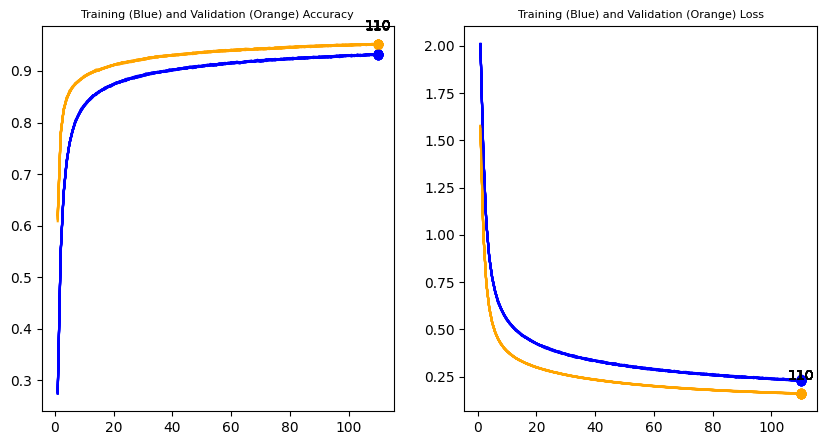

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import time
nb_epoch = 50
patience = 0
df.groupby("cost")

for x, group in df.groupby("cost"):
  fig = plt.figure(figsize=(20, 10)) 
  fig, ax = plt.subplots(1,2)
  print("Group of Lambda-Value:",   x)

  # group
  for item in group.model_history:
    plot_model_history_all(item)    
  plt.show()
    # for item, cm3 in zip(group.model_history, group.cm):

  #   # cm3_wodiag = cm3*(np.ones((10,10)) - np.eye(10))

  #   # ax[2] = sns.heatmap(cm3_wodiag, annot=True, annot_kws={"size": 7},  fmt='g', cmap=sns.cm.rocket_r, cbar=False) # font size
  #   # ax[2].set_xlabel('Predicted Class')
  #   # ax[2].set_ylabel('True Class')
  #   # ax[2].set_title('# of misclassifications of 9 as 4 is '+str(cm3[4][9]))
  #   # cbar = ax[2].collections[0].colorbar
  #   # cbar.remove() # Just takes up valuable room and is worthless
  #   plot_model_history_all(item)    

  #   #   ax[0].set_title("Lambda Value of"+str(df["cost"]))
    
  # #   # print(0+r,' to ', r+4+1)  #Correct

In [91]:
# for item, cm3 in zip(group.model_history, group.cm):

#     cm3_wodiag = cm3*(np.ones((10,10)) - np.eye(10))

#     ax[2] = sns.heatmap(cm3_wodiag, annot=True, annot_kws={"size": 7},  fmt='g', cmap=sns.cm.rocket_r, cbar=False) # font size
#     ax[2].set_xlabel('Predicted Class')
#     ax[2].set_ylabel('True Class')
#     ax[2].set_title('# of misclassifications of 9 as 4 is '+str(cm3[4][9]))
#     cbar = ax[2].collections[0].colorbar
#     cbar.remove() # Just takes up valuable room and is worthless
#     plot_model_history_all(item)    

#     #   ax[0].set_title("Lambda Value of"+str(df["cost"]))
    
#   #   # print(0+r,' to ', r+4+1)  #Correct

AttributeError: ignored

In [93]:
df["model_history"][0].history.keys()
# The last run captured is "13" for the 14th run

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', '9T_4P', '4T_9P', '0T_Acc', '1T_Acc', '2T_Acc', '3T_Acc', '4T_Acc', '5T_Acc', '6T_Acc', '7T_Acc', '8T_Acc', '9T_Acc', 'cm_per_epoch', 'f1_micro', 'f1_macro', 'f1_weighted', 'f1_notweighted'])

The plots of the 14 (15?) completed runs look very similar.  The loss values, even with shuffling, are nearly identical at least within 0.01 for the first three epochs of runs 1 and 2 (haven't checked all, but the plot makes it look like the runs are nearly identical)

In [69]:
df["model_history"][2].history["val_loss"][0] - df["model_history"][1].history["val_loss"][0]
df["model_history"][2].history["val_loss"][1] - df["model_history"][1].history["val_loss"][1]
df["model_history"][2].history["val_loss"][2] - df["model_history"][1].history["val_loss"][2]

0.0016095638275146484

What is clear however is there doesn't seem to be any overfitting with the small learning rate, and that training could probably continue for another 20 epochs or more.

In [111]:
import matplotlib.pyplot as plt
import seaborn as sns


What is the highest misclassification?



0


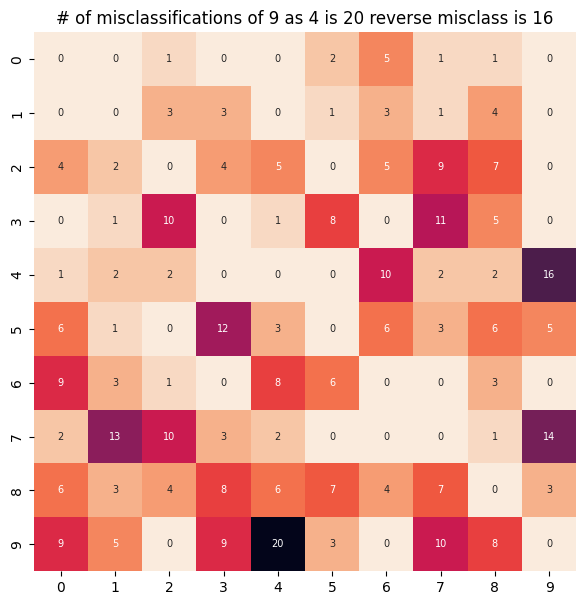

1


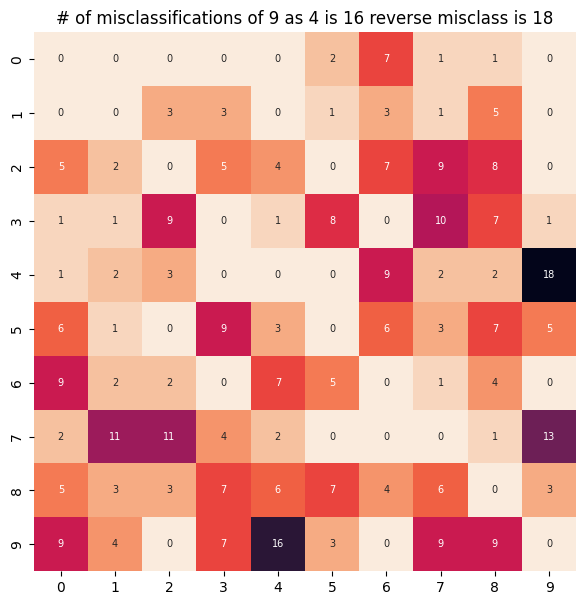

2


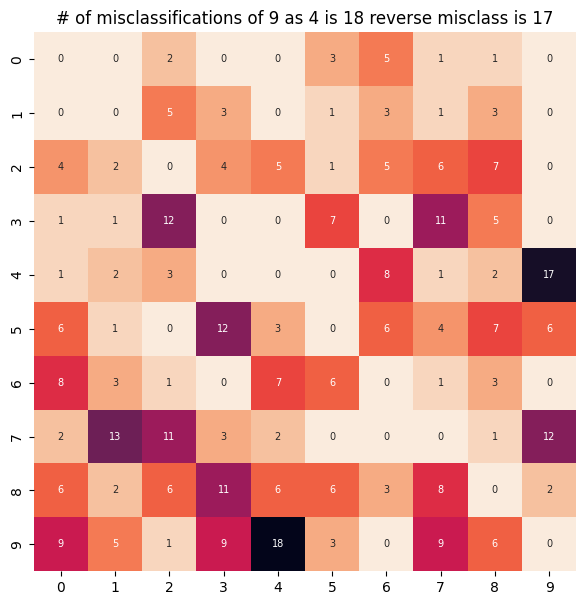

3


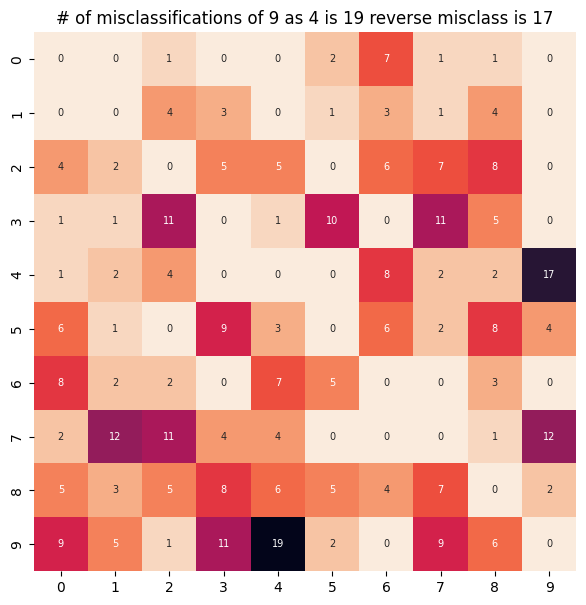

4


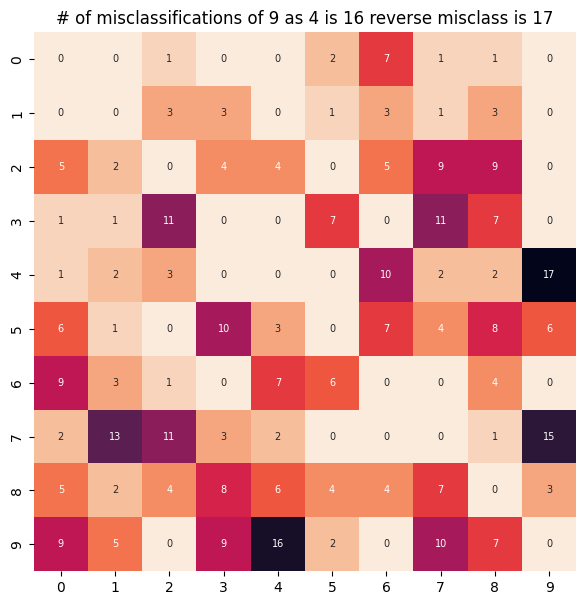

5


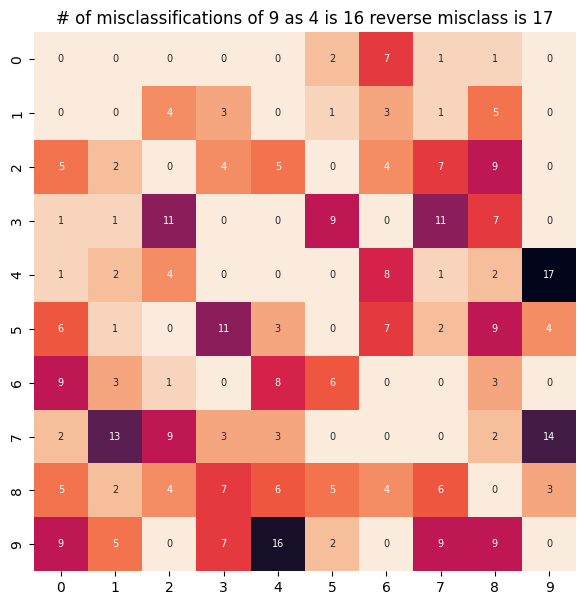

6


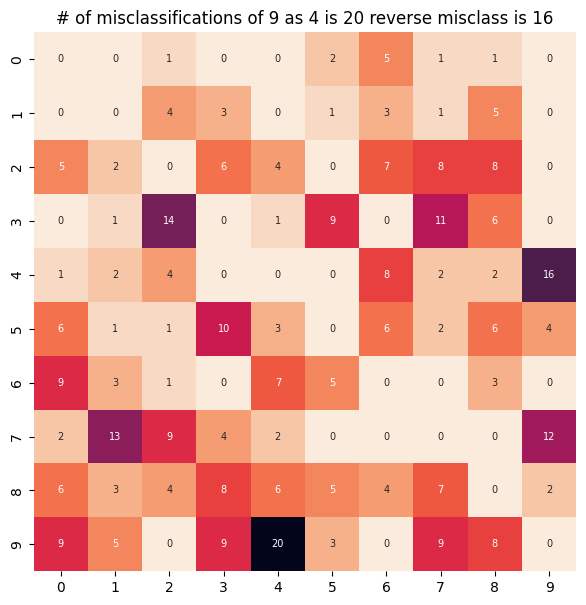

7


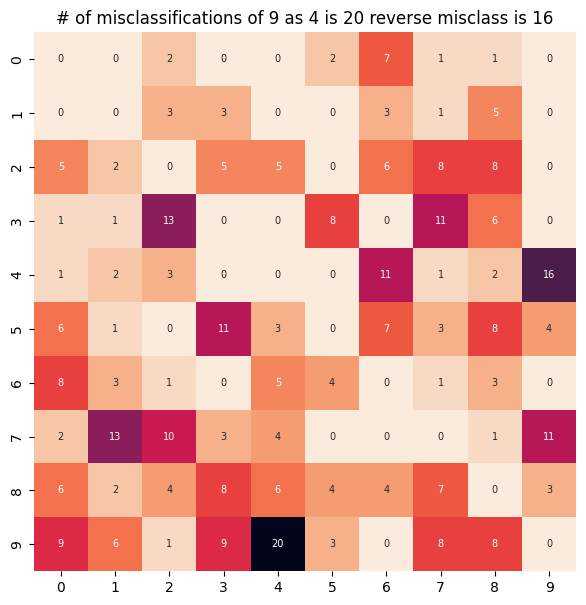

8


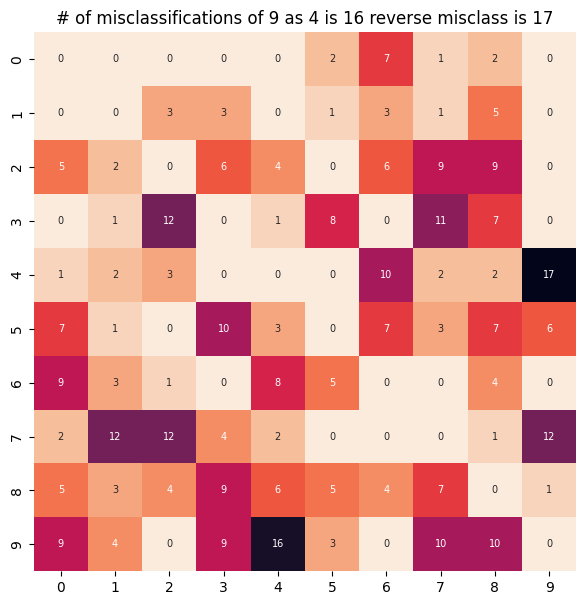

9


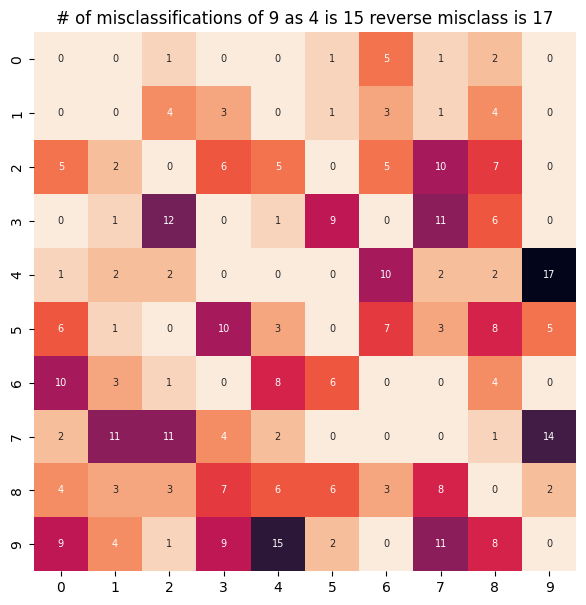

10


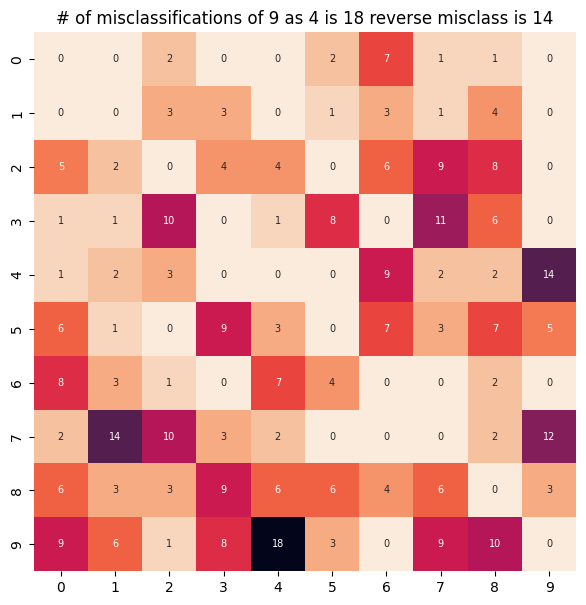

11


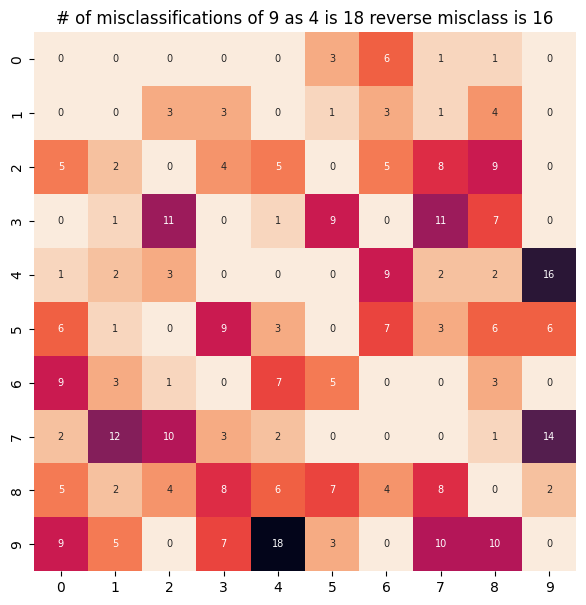

12


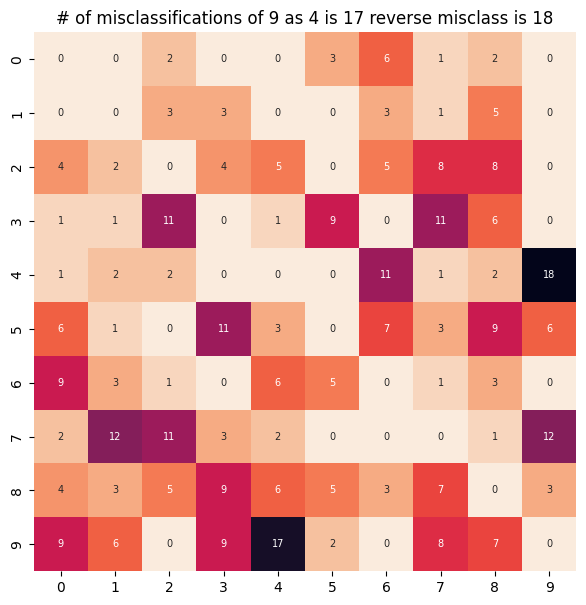

13


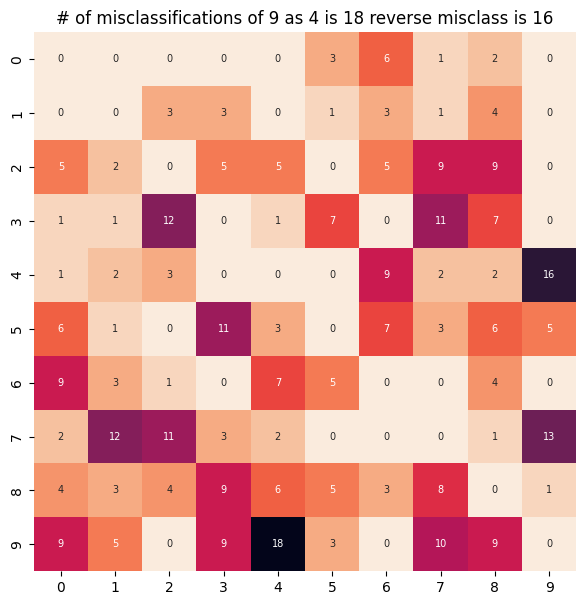

In [112]:
for i in range(len(df["model_history"])):
  print(i)
  cm = df["model_history"][i].history["cm_per_epoch"][-1]
  cm = cm.reshape((10,10))
  

  # Create figure and axes
  fig, ax = plt.subplots(figsize=(7, 7))


  cm3_wodiag = pd.DataFrame(cm*(np.ones((10,10)) - np.eye(10)))
  plt.xlabel('Predicted Class')
  plt.ylabel('True Class')
  plt.title('# of misclassifications of 9 as 4 is '+str(cm[9][4]) + ' reverse misclass is ' + str(cm[4][9])  ) 
  sns.heatmap(cm3_wodiag, annot=True, annot_kws={"size": 7},  fmt='g', cmap=sns.cm.rocket_r, cbar=False) # font size
  plt.show()




  
  